# Training a Classifier

In [32]:
import torch
import torchvision
import torchvision.transforms as transforms

In [33]:
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=4, shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=4, shuffle=True, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


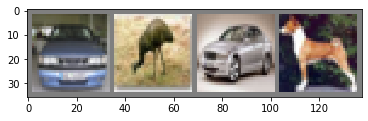

  car  bird   car   dog


In [34]:
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np

def imshow(img):
    img = img / 2 + 0.5
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

detaiter = iter(trainloader)
images, labels = detaiter.next()

imshow(torchvision.utils.make_grid(images))
print(' '.join('%5s' % classes[labels[j]] for j in range(4)))

In [35]:
import torch.nn as nn
import torch.nn.functional as F

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16*5*5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)
    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16*5*5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x
    
net = Net()
print(net)

Net(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)


In [36]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

In [37]:
# train network
for epoch in range(2):
    running_loss = 0.0
    for i, data in enumerate(trainloader, 1):
        inputs, labels = data
        
        optimizer.zero_grad()
        
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        if i % 2000 == 0:
            print("[{}, {}] loss : {}".format(epoch, i, running_loss/2000))
            running_loss = 0.0
print("finished")

[0, 2000] loss : 2.2073302889466286
[0, 4000] loss : 1.8885677919685842
[0, 6000] loss : 1.6815557517409325
[0, 8000] loss : 1.6131714489012956
[0, 10000] loss : 1.542418323725462
[0, 12000] loss : 1.488505921140313
[1, 2000] loss : 1.4158998126387596
[1, 4000] loss : 1.3843143078535796
[1, 6000] loss : 1.353279986679554
[1, 8000] loss : 1.306077224947512
[1, 10000] loss : 1.3104032893329858
[1, 12000] loss : 1.2943186229094863
finished


In [38]:
PATH = "./cifar_net.pth"
torch.save(net.state_dict(), PATH)

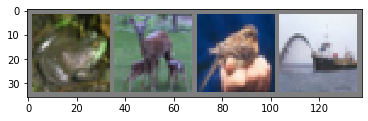

GroundTruth :   frog  deer  bird  ship


In [57]:
dataiter = iter(testloader)
images, labels = dataiter.next()

imshow(torchvision.utils.make_grid(images))
print("GroundTruth : ", " ".join("%5s" % classes[labels[j]] for j in range(4)))

In [58]:
net = Net()
net.load_state_dict(torch.load(PATH))

<All keys matched successfully>

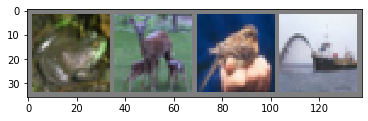

tensor([[ 1.3902, -0.0830, -0.8717, -0.0064, -0.5896, -0.2676, -2.5475, -0.0395,
          2.3267,  0.7761],
        [ 5.9888,  5.0380, -0.3182, -3.0149, -2.6691, -4.4859, -2.4083, -4.4546,
          5.0805,  1.7043],
        [ 3.9008,  3.9454,  0.8612, -1.0235, -1.9130, -3.2344, -3.3999, -2.9918,
          3.2002,  0.9469],
        [-1.7082, -2.8469,  0.7034,  2.2756,  1.8628,  2.1174,  1.8042,  2.5675,
         -3.3131, -1.9453]])
tensor([8, 0, 1, 7])
Predicted:   ship plane   car horse


In [59]:
ouputs = net(images)
imshow(torchvision.utils.make_grid(images))
print(outputs)

_, predicted = torch.max(outputs, 1)
print(predicted)
print('Predicted: ', ' '.join('%5s' % classes[predicted[j]] for j in range(4)))

In [60]:
correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 10000 test images: %d %%' % (100 * correct / total))

Accuracy of the network on the 10000 test images: 53 %


In [61]:
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, predicted = torch.max(outputs, 1)
        c = (predicted == labels).squeeze()
        for i in range(4):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1

for i in range(10):
    print('Accuracy of %5s : %2d %%' % (
        classes[i], 100 * class_correct[i] / class_total[i]))

Accuracy of plane : 72 %
Accuracy of   car : 85 %
Accuracy of  bird : 44 %
Accuracy of   cat : 37 %
Accuracy of  deer : 30 %
Accuracy of   dog : 46 %
Accuracy of  frog : 66 %
Accuracy of horse : 48 %
Accuracy of  ship : 65 %
Accuracy of truck : 40 %


In [62]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [63]:
net.to(device)

Net(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)

In [64]:
# train network
for epoch in range(2):
    running_loss = 0.0
    for i, data in enumerate(trainloader, 1):
        inputs, labels = data[0].to(device), data[1].to(device)
        
        optimizer.zero_grad()
        
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        if i % 2000 == 0:
            print("[{}, {}] loss : {}".format(epoch, i, running_loss/2000))
            running_loss = 0.0
print("finished")

[0, 2000] loss : 1.25731122790277
[0, 4000] loss : 1.2496604176610708
[0, 6000] loss : 1.2685334708541631
[0, 8000] loss : 1.2683844698667526
[0, 10000] loss : 1.2708205555230379
[0, 12000] loss : 1.275092945188284
[1, 2000] loss : 1.2624263044595718
[1, 4000] loss : 1.2714725670665503
[1, 6000] loss : 1.254896562859416
[1, 8000] loss : 1.2640273205041885
[1, 10000] loss : 1.256846107378602
[1, 12000] loss : 1.266979834318161
finished


# Done